In [1]:
using Pkg
using SSM
using Random
using Distributions
using LinearAlgebra
using Plots
using ForwardDiff
using Optim

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
Random.seed!(1234)

function toy_PoissonLDS()
    T = 100
    # create a PLDS model
    x0 = [1.0, -1.0]
    p0 = Matrix(Diagonal([0.1, 0.1]))
    A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
    Q = Matrix(Diagonal([0.1, 0.1]))
    C = [0.6 0.6; 0.6 0.6; 0.6 0.6] .* 2
    log_d = log.([0.1, 0.1, 0.1])

    plds = PoissonLDS(A=A, C=C, Q=Q, log_d=log_d, x0=x0, p0=p0, refractory_period=1, obs_dim=3, latent_dim=2)
    # sample data
    x, y = SSM.sample(plds, T, 1)
    return plds, x, y
end

# plds, x, y_array = toy_PoissonLDS()
# plds.fit_bool = [true, true, true, true, true, true]
x0 = [1.0, -1.0]
p0 = Matrix(Diagonal([0.1, 0.1]))
A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
Q = Matrix(Diagonal([0.1, 0.1]))
C = [0.6 0.6; 0.6 0.6; 0.6 0.6] .* 2
log_d = log.([0.1, 0.1, 0.1])

plds = PoissonLDS(;A=A, Q=Q, C=C, log_d=log_d, x0=x0, P0=p0, obs_dim=3, latent_dim=2)
x, y = SSM.sample(plds, 100, 3)

([0.8862437314235312 1.2277292110548945 … -2.8856144939792046 -3.155128854666202; 1.0824296450425381 0.9578877101533626 … -2.77853848134019 -2.589813048361797; 0.7692093419200826 0.7256148494904646 … -3.2949248692224318 -4.455003201354699;;; -0.656194487244774 -0.5601470954101622 … -1.541922037605218 -2.309869642040568; -0.9502846000156316 -0.27621441263456015 … -0.7589148977585677 -1.287423615011598; -0.7560196049859244 -0.22995757032678277 … 4.453333242668746 3.884943232113579], [2.0 3.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; 1.0 1.0 … 5.0 1.0;;; 1.0 3.0 … 0.0 0.0; 1.0 1.0 … 0.0 0.0; 0.0 3.0 … 8.0 1.0;;; 3.0 1.0 … 0.0 0.0; 1.0 0.0 … 1.0 0.0; 1.0 0.0 … 5.0 0.0])

In [3]:
x_smooth, p_smooth, p_tt1 = SSM.smooth(plds, y)

([1.2360299440959632 1.4257302423682012 … -3.392267544526504 -3.237532182639153; 1.0556818103864272 1.2477847524779988 … -1.4352577494436187 -1.3442753967856638; 0.9826704359824329 1.1697199275964572 … -3.1269782533974806 -3.807153353689087;;; -0.9169793149713987 -0.832327763437846 … -1.3905347417548213 -1.7232831994933977; -1.068470285626432 -0.9854908152539941 … -1.0304703499117058 -1.187672308880082; -1.1311822664824818 -1.057956897406381 … 4.544250972716873 3.967242856987218], [0.05918169053158917 0.09485545018674346 … 1.5899891978378924 1.6957633921914588; 0.061856019710548854 0.0970056383423021 … 0.9611768127470769 1.1020168612392334; 0.06319350896668953 0.0995057885038757 … 0.4890582610698183 0.5926877412489846;;; -0.029516491118826857 -0.06861258157750207 … -0.08768219956261071 -0.013355881873559324; -0.026402771464539072 -0.06563387651405023 … -0.3842523243822594 -0.36331897317959894; -0.02493520439574122 -0.06267018737912769 … -0.4689803350591435 -0.49535778189981405;;;; -0.0

In [44]:
"""
    mutable struct PoissonPCA end
A probabilsitic (PCA?) model for Poisson distributed data.
# Fields
- `C::Matrix{<:Real}`: The loading matrix
- `log_d::Vector{<:Real}`: The log bias vector
- `latent_dim::Int64`: The latent dimensionality
- `obs_dim::Int64`: The observation dimensionality
"""
mutable struct PoissonPCA 
    C::Matrix{<:Real}
    log_d::Vector{<:Real}
    latent_dim::Int64
    obs_dim::Int64
end

"""
    PoissonPCA(;C::Matrix{<:Real}=Matrix{Float64}(undef, 0, 0), d::Vector{<:Real}=Vector{Float64}(undef, 0), latent_dim::Int64, obs_dim::Int64)
Constructor for PoissonPCA
# Arguments
- `C::Matrix{<:Real}`: The loading matrix
- `log_d::Vector{<:Real}`: The log bias vector
- `latent_dim::Int64`: The latent dimensionality
- `obs_dim::Int64`: The observation dimensionality
"""
function PoissonPCA(;C::Matrix{<:Real}=Matrix{Float64}(undef, 0, 0), log_d::Vector{<:Real}=Vector{Float64}(undef, 0), latent_dim::Int64, obs_dim::Int64)
    # initialize C
    if isempty(C)
        C = randn(obs_dim, latent_dim)
    end
    # initialize b
    if isempty(log_d)
        log_d = rand(obs_dim)
    end
    return PoissonPCA(C, log_d, latent_dim, obs_dim)
end

"""
    gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    
Calculate the gradient of the Poisson PCA model. Designed to be passed to LBFGS in Optim.jl.
# Arguments
- `grad::Vector{<:Real}`: The gradient vector
- `x::Vector{<:Real}`: The latent variables
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function gradient!(grad::Vector{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    T, n = size(y)
    x_mat = reshape(x, T, model.latent_dim)
    d = exp.(model.log_d)
    
    gradient = zeros(T, model.latent_dim)
    for t in 1:T
        λt = exp.(model.C * x_mat[t, :] .+ d)
        gradient[t, :] = model.C' * (y[t, :] - λt)
    end
    
    grad .= -vec(gradient)
end

"""
    hessian!(hess::Matrix{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})

Calculate the Hessian of the Poisson PCA model. Designed to be passed to LBFGS in Optim.jl.

# Arguments
- `hess::Matrix{<:Real}`: The Hessian matrix
- `x::Vector{<:Real}`: The latent variables
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function hessian!(hess::Matrix{<:Real}, x::Vector{<:Real}, model::PoissonPCA, y::Matrix{<:Real})
    T, n = size(y)
    k = model.latent_dim
    x_mat = reshape(x, T, k)
    d = exp.(model.log_d)
    
    # Initialize Hessian
    H = zeros(T * k, T * k)
    
    for t in 1:T
        λt = exp.(model.C * x_mat[t, :] .+ d)
        H_block = -model.C' * Diagonal(λt) * model.C
        
        # Place the block in the correct position in the Hessian
        start_idx = (t - 1) * k + 1
        end_idx = t * k
        H[start_idx:end_idx, start_idx:end_idx] = H_block
    end
    
    hess .= -H  # Negative because we're working with log-likelihood
end

"""
    loglikelihood_(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
Calculate the log-likelihood of the Poisson PCA model.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `x::Matrix{<:Real}`: The latent variables
- `y::Matrix{<:Real}`: The observed data
"""
function loglikelihood_(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    d = exp.(model.log_d)
    T = size(y, 1)
    ll = 0.0
    for t in 1:T
        ll += sum(y[t, :] .* (model.C * x[t, :] + model.b)) - sum(exp.(model.C * x[t, :] + d))
    end
    return ll
end

"""
    E_Step(model::PoissonPCA, y::Matrix{<:Real})
E-Step for Poisson PCA. Computes a MAP estimate of the latent variables by optimiizing the log-likelihood w.r.t. the latent variables.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
"""
function E_Step(model::PoissonPCA, y::Matrix{<:Real})
    # create an objective function to minimize
    function obj(x)
        x = reshape(x, size(y, 1), model.latent_dim)
        return -loglikelihood_(model, x, y)
    end
    # create a wrapper for gradient
    function grad!(g, x)
        gradient!(g, x, model, y)
    end
    # optimize the objective function
    res = optimize(obj, grad!, vec(rand(size(y, 1), model.latent_dim)), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    return reshape(res.minimizer, size(y, 1), model.latent_dim)
end

function Q_function(model::PoissonPCA, E_z::Matrix{<:Real}, P_sm::Matrix{<:Real}, y::Matrix{<:Real})
    # Calculate the Q function
    Q = 0.0
    for t in axes(y, 1)
        # compute the linear term
        term_1 = 

"""
    M_Step!(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
M-Step for Poisson PCA
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `x::Matrix{<:Real}`: The latent variables
- `y::Matrix{<:Real}`: The observed data
"""
function M_Step!(model::PoissonPCA, x::Matrix{<:Real}, y::Matrix{<:Real})
    # define objective function to minimize
    function obj(params)
        C = reshape(params[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
        b = params[model.latent_dim * model.obs_dim + 1:end]
        return -loglikelihood_(PoissonPCA(C, b, model.latent_dim, model.obs_dim), x, y)
    end
    # optimize the objective function
    res = optimize(obj, vcat(reshape(model.C, model.latent_dim * model.obs_dim), model.b), LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000), autodiff=:forward)
    model.C = reshape(res.minimizer[1:model.latent_dim * model.obs_dim], model.obs_dim, model.latent_dim)
    model.b = res.minimizer[model.latent_dim * model.obs_dim + 1:end]
end

"""
    fit!(model::PoissonPCA, y::Matrix{<:Real}, max_iters::Int=100, tol=1e-6)
Fit the Poisson PCA model to the data.
# Arguments
- `model::PoissonPCA`: The Poisson PCA model
- `y::Matrix{<:Real}`: The observed data
- `max_iters::Int=100`: The maximum number of iterations
- `tol::Float64=1e-6`: The tolerance for convergence
"""
function fit!(model::PoissonPCA, y::Matrix{<:Real}, max_iters::Int=100, tol=1e-6)
    # set up first ll
    ll_prev = -Inf
    # Go!
    prog = Progress(max_iters; desc="Fitting Poisson PCA...")
    for i in 1:max_iters
        x = E_Step(model, y)
        M_Step!(model, x, y)
        #println("Log-Likelihood at iter $i: $(loglikelihood_(model, x, y))")
        next!(prog)
        # check for convergence
        ll = loglikelihood_(model, x, y)
        if abs(ll - ll_prev) < tol
            #println("Converged after $i iterations")
            finish!(prog)
            break
        end
    end
end

ErrorException: syntax: extra token "the" after end of expression

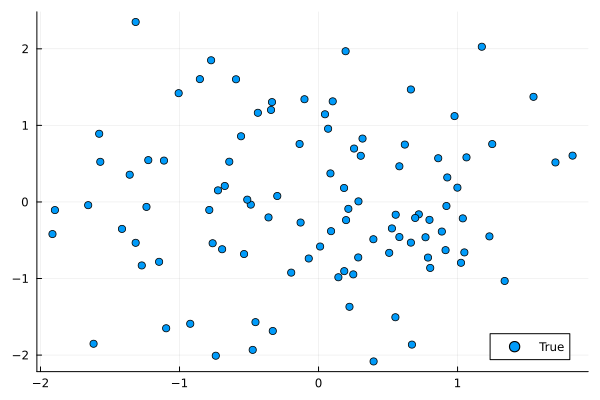

In [66]:
function simulate_poisson_pca(n::Int, T::Int, k::Int; seed=123)
    Random.seed!(seed)
    
    # Generate model parameters
    C = randn(n, k)
    log_d = randn(n)
    d = exp.(log_d)
    
    # Generate latent variables X
    X = randn(T, k)
    
    # Generate observed data Y
    Y = zeros(Int, T, n)
    for t in 1:T
        λ = exp.(C * X[t, :] .+ d)
        Y[t, :] = rand.(Poisson.(λ))
    end
    
    model = PoissonPCA(;C=C, log_d=log_d, latent_dim=k, obs_dim=n)
    return model, X, Y
end

# Simulate data
n, T, k = 10, 100, 2
model, true_X, Y = simulate_poisson_pca(n, T, k)

scatter(true_X[:, 1], true_X[:, 2], label="True")